# GANomaly
- 2020.08.17 : gen 15 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 15)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3883 / DC_loss : 0.6150
- D(x):0.5005 / D(DC(z1)) : 0.5014 / D(DC(z2)) : 0.5406
[1/100][1/15]
- D_loss : 1.3801 / DC_loss : 0.6128
- D(x):0.5010 / D(DC(z1)) : 0.4978 / D(DC(z2)) : 0.5418
[1/100][2/15]
- D_loss : 1.3724 / DC_loss : 0.6178
- D(x):0.5011 / D(DC(z1)) : 0.4940 / D(DC(z2)) : 0.5392
[1/100][3/15]
- D_loss : 1.3646 / DC_loss : 0.6200
- D(x):0.5017 / D(DC(z1)) : 0.4906 / D(DC(z2)) : 0.5380
[1/100][4/15]
- D_loss : 1.3571 / DC_loss : 0.6250
- D(x):0.5019 / D(DC(z1)) : 0.4870 / D(DC(z2)) : 0.5353
[1/100][5/15]
- D_loss : 1.3543 / DC_loss : 0.6292
- D(x):0.5008 / D(DC(z1)) : 0.4844 / D(DC(z2)) : 0.5331
[1/100][6/15]
- D_loss : 1.3501 / DC_loss : 0.6309
- D(x):0.5006 / D(DC(z1)) : 0.4819 / D(DC(z2)) : 0.5322
[1/100][7/15]
- D_loss : 1.3455 / DC_loss : 0.6303
- D(x):0.5013 / D(DC(z1)) : 0.4802 / D(DC(z2)) : 0.5325
[1/100][8/15]
- D_loss : 1.3453 / DC_loss : 0.6307
- D(x):0.5009 / D(DC(z1)) : 0.4797 / D(DC(z2)) : 0.5323
[1/100][9/15]
- D_loss : 1.3502 / DC_

[6/100][2/15]
- D_loss : 1.5448 / DC_loss : 0.6088
- D(x):0.4717 / D(DC(z1)) : 0.5470 / D(DC(z2)) : 0.5440
[6/100][3/15]
- D_loss : 1.5436 / DC_loss : 0.6169
- D(x):0.4684 / D(DC(z1)) : 0.5433 / D(DC(z2)) : 0.5396
[6/100][4/15]
- D_loss : 1.5253 / DC_loss : 0.6255
- D(x):0.4726 / D(DC(z1)) : 0.5390 / D(DC(z2)) : 0.5350
[6/100][5/15]
- D_loss : 1.5218 / DC_loss : 0.6334
- D(x):0.4695 / D(DC(z1)) : 0.5344 / D(DC(z2)) : 0.5308
[6/100][6/15]
- D_loss : 1.5129 / DC_loss : 0.6379
- D(x):0.4698 / D(DC(z1)) : 0.5303 / D(DC(z2)) : 0.5284
[6/100][7/15]
- D_loss : 1.5084 / DC_loss : 0.6423
- D(x):0.4698 / D(DC(z1)) : 0.5282 / D(DC(z2)) : 0.5261
[6/100][8/15]
- D_loss : 1.4906 / DC_loss : 0.6443
- D(x):0.4759 / D(DC(z1)) : 0.5260 / D(DC(z2)) : 0.5250
[6/100][9/15]
- D_loss : 1.5049 / DC_loss : 0.6452
- D(x):0.4682 / D(DC(z1)) : 0.5249 / D(DC(z2)) : 0.5246
[6/100][10/15]
- D_loss : 1.5043 / DC_loss : 0.6436
- D(x):0.4678 / D(DC(z1)) : 0.5244 / D(DC(z2)) : 0.5254
[6/100][11/15]
- D_loss : 1.4983 / D

[11/100][4/15]
- D_loss : 1.4193 / DC_loss : 0.7274
- D(x):0.4689 / D(DC(z1)) : 0.4833 / D(DC(z2)) : 0.4832
[11/100][5/15]
- D_loss : 1.4079 / DC_loss : 0.7279
- D(x):0.4746 / D(DC(z1)) : 0.4836 / D(DC(z2)) : 0.4829
[11/100][6/15]
- D_loss : 1.4220 / DC_loss : 0.7283
- D(x):0.4676 / D(DC(z1)) : 0.4833 / D(DC(z2)) : 0.4827
[11/100][7/15]
- D_loss : 1.4009 / DC_loss : 0.7279
- D(x):0.4774 / D(DC(z1)) : 0.4832 / D(DC(z2)) : 0.4829
[11/100][8/15]
- D_loss : 1.4163 / DC_loss : 0.7274
- D(x):0.4705 / D(DC(z1)) : 0.4834 / D(DC(z2)) : 0.4832
[11/100][9/15]
- D_loss : 1.4062 / DC_loss : 0.7287
- D(x):0.4754 / D(DC(z1)) : 0.4836 / D(DC(z2)) : 0.4826
[11/100][10/15]
- D_loss : 1.4036 / DC_loss : 0.7308
- D(x):0.4760 / D(DC(z1)) : 0.4830 / D(DC(z2)) : 0.4815
[11/100][11/15]
- D_loss : 1.4048 / DC_loss : 0.7333
- D(x):0.4744 / D(DC(z1)) : 0.4819 / D(DC(z2)) : 0.4803
[11/100][12/15]
- D_loss : 1.4081 / DC_loss : 0.7327
- D(x):0.4718 / D(DC(z1)) : 0.4808 / D(DC(z2)) : 0.4806
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.3222 / DC_loss : 0.8036
- D(x):0.4824 / D(DC(z1)) : 0.4467 / D(DC(z2)) : 0.4477
[16/100][6/15]
- D_loss : 1.3233 / DC_loss : 0.8009
- D(x):0.4831 / D(DC(z1)) : 0.4482 / D(DC(z2)) : 0.4489
[16/100][7/15]
- D_loss : 1.3163 / DC_loss : 0.7958
- D(x):0.4877 / D(DC(z1)) : 0.4494 / D(DC(z2)) : 0.4512
[16/100][8/15]
- D_loss : 1.3383 / DC_loss : 0.7907
- D(x):0.4792 / D(DC(z1)) : 0.4518 / D(DC(z2)) : 0.4535
[16/100][9/15]
- D_loss : 1.3282 / DC_loss : 0.7892
- D(x):0.4859 / D(DC(z1)) : 0.4540 / D(DC(z2)) : 0.4542
[16/100][10/15]
- D_loss : 1.3254 / DC_loss : 0.7917
- D(x):0.4877 / D(DC(z1)) : 0.4546 / D(DC(z2)) : 0.4531
[16/100][11/15]
- D_loss : 1.3279 / DC_loss : 0.7961
- D(x):0.4855 / D(DC(z1)) : 0.4534 / D(DC(z2)) : 0.4511
[16/100][12/15]
- D_loss : 1.3233 / DC_loss : 0.8017
- D(x):0.4860 / D(DC(z1)) : 0.4514 / D(DC(z2)) : 0.4486
[16/100][13/15]
- D_loss : 1.3164 / DC_loss : 0.8087
- D(x):0.4870 / D(DC(z1)) : 0.4488 / D(DC(z2)) : 0.4454
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.2740 / DC_loss : 0.8136
- D(x):0.4993 / D(DC(z1)) : 0.4394 / D(DC(z2)) : 0.4432
[21/100][7/15]
- D_loss : 1.2742 / DC_loss : 0.8108
- D(x):0.5032 / D(DC(z1)) : 0.4439 / D(DC(z2)) : 0.4445
[21/100][8/15]
- D_loss : 1.2867 / DC_loss : 0.8147
- D(x):0.4981 / D(DC(z1)) : 0.4450 / D(DC(z2)) : 0.4428
[21/100][9/15]
- D_loss : 1.2885 / DC_loss : 0.8207
- D(x):0.4956 / D(DC(z1)) : 0.4431 / D(DC(z2)) : 0.4401
[21/100][10/15]
- D_loss : 1.2752 / DC_loss : 0.8282
- D(x):0.4997 / D(DC(z1)) : 0.4405 / D(DC(z2)) : 0.4368
[21/100][11/15]
- D_loss : 1.2685 / DC_loss : 0.8355
- D(x):0.5002 / D(DC(z1)) : 0.4372 / D(DC(z2)) : 0.4337
[21/100][12/15]
- D_loss : 1.2643 / DC_loss : 0.8427
- D(x):0.4994 / D(DC(z1)) : 0.4340 / D(DC(z2)) : 0.4306
[21/100][13/15]
- D_loss : 1.2664 / DC_loss : 0.8507
- D(x):0.4956 / D(DC(z1)) : 0.4307 / D(DC(z2)) : 0.4271
[21/100][14/15]
- D_loss : 1.2540 / DC_loss : 0.8582
- D(x):0.4989 / D(DC(z1)) : 0.4274 / D(DC(z2)) : 0.4239
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.1359 / DC_loss : 0.9871
- D(x):0.5139 / D(DC(z1)) : 0.3747 / D(DC(z2)) : 0.3727
[26/100][8/15]
- D_loss : 1.1434 / DC_loss : 0.9920
- D(x):0.5089 / D(DC(z1)) : 0.3731 / D(DC(z2)) : 0.3708
[26/100][9/15]
- D_loss : 1.1329 / DC_loss : 0.9981
- D(x):0.5128 / D(DC(z1)) : 0.3713 / D(DC(z2)) : 0.3686
[26/100][10/15]
- D_loss : 1.1274 / DC_loss : 1.0042
- D(x):0.5137 / D(DC(z1)) : 0.3690 / D(DC(z2)) : 0.3663
[26/100][11/15]
- D_loss : 1.1181 / DC_loss : 1.0094
- D(x):0.5166 / D(DC(z1)) : 0.3667 / D(DC(z2)) : 0.3644
[26/100][12/15]
- D_loss : 1.1268 / DC_loss : 1.0133
- D(x):0.5106 / D(DC(z1)) : 0.3648 / D(DC(z2)) : 0.3630
[26/100][13/15]
- D_loss : 1.1225 / DC_loss : 1.0157
- D(x):0.5117 / D(DC(z1)) : 0.3634 / D(DC(z2)) : 0.3621
[26/100][14/15]
- D_loss : 1.0962 / DC_loss : 1.0184
- D(x):0.5245 / D(DC(z1)) : 0.3625 / D(DC(z2)) : 0.3612
[27/100][0/15]
- D_loss : 1.1102 / DC_loss : 1.0214
- D(x):0.5165 / D(DC(z1)) : 0.3615 / D(DC(z2)) : 0.3601
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.2006 / DC_loss : 0.9455
- D(x):0.5040 / D(DC(z1)) : 0.4022 / D(DC(z2)) : 0.3885
[31/100][9/15]
- D_loss : 1.1561 / DC_loss : 0.9886
- D(x):0.5155 / D(DC(z1)) : 0.3890 / D(DC(z2)) : 0.3721
[31/100][10/15]
- D_loss : 1.1701 / DC_loss : 0.9876
- D(x):0.4952 / D(DC(z1)) : 0.3727 / D(DC(z2)) : 0.3725
[31/100][11/15]
- D_loss : 1.1547 / DC_loss : 0.9834
- D(x):0.5033 / D(DC(z1)) : 0.3730 / D(DC(z2)) : 0.3740
[31/100][12/15]
- D_loss : 1.1462 / DC_loss : 1.0034
- D(x):0.5087 / D(DC(z1)) : 0.3747 / D(DC(z2)) : 0.3666
[31/100][13/15]
- D_loss : 1.1170 / DC_loss : 1.0296
- D(x):0.5176 / D(DC(z1)) : 0.3673 / D(DC(z2)) : 0.3572
[31/100][14/15]
- D_loss : 1.1380 / DC_loss : 0.9941
- D(x):0.4996 / D(DC(z1)) : 0.3578 / D(DC(z2)) : 0.3701
[32/100][0/15]
- D_loss : 1.1047 / DC_loss : 0.9751
- D(x):0.5273 / D(DC(z1)) : 0.3714 / D(DC(z2)) : 0.3771
[32/100][1/15]
- D_loss : 1.1604 / DC_loss : 0.9094
- D(x):0.5059 / D(DC(z1)) : 0.3798 / D(DC(z2)) : 0.4028
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.1201 / DC_loss : 0.9551
- D(x):0.5397 / D(DC(z1)) : 0.3953 / D(DC(z2)) : 0.3848
[36/100][10/15]
- D_loss : 1.1213 / DC_loss : 0.9754
- D(x):0.5304 / D(DC(z1)) : 0.3854 / D(DC(z2)) : 0.3770
[36/100][11/15]
- D_loss : 1.0806 / DC_loss : 1.0005
- D(x):0.5454 / D(DC(z1)) : 0.3776 / D(DC(z2)) : 0.3677
[36/100][12/15]
- D_loss : 1.0770 / DC_loss : 0.9951
- D(x):0.5395 / D(DC(z1)) : 0.3685 / D(DC(z2)) : 0.3697
[36/100][13/15]
- D_loss : 1.1058 / DC_loss : 0.9007
- D(x):0.5273 / D(DC(z1)) : 0.3721 / D(DC(z2)) : 0.4063
[36/100][14/15]
- D_loss : 1.1697 / DC_loss : 0.8675
- D(x):0.5260 / D(DC(z1)) : 0.4095 / D(DC(z2)) : 0.4200
[37/100][0/15]
- D_loss : 1.1848 / DC_loss : 0.9001
- D(x):0.5291 / D(DC(z1)) : 0.4219 / D(DC(z2)) : 0.4065
[37/100][1/15]
- D_loss : 1.1886 / DC_loss : 0.9446
- D(x):0.5149 / D(DC(z1)) : 0.4079 / D(DC(z2)) : 0.3888
[37/100][2/15]
- D_loss : 1.1452 / DC_loss : 0.9821
- D(x):0.5222 / D(DC(z1)) : 0.3904 / D(DC(z2)) : 0.3745
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.2099 / DC_loss : 0.8402
- D(x):0.5185 / D(DC(z1)) : 0.4245 / D(DC(z2)) : 0.4317
[41/100][11/15]
- D_loss : 1.2352 / DC_loss : 0.7790
- D(x):0.5130 / D(DC(z1)) : 0.4323 / D(DC(z2)) : 0.4590
[41/100][12/15]
- D_loss : 1.2468 / DC_loss : 0.7455
- D(x):0.5336 / D(DC(z1)) : 0.4610 / D(DC(z2)) : 0.4747
[41/100][13/15]
- D_loss : 1.2900 / DC_loss : 0.7469
- D(x):0.5218 / D(DC(z1)) : 0.4720 / D(DC(z2)) : 0.4741
[41/100][14/15]
- D_loss : 1.3225 / DC_loss : 0.7448
- D(x):0.5083 / D(DC(z1)) : 0.4752 / D(DC(z2)) : 0.4750
[42/100][0/15]
- D_loss : 1.3038 / DC_loss : 0.7417
- D(x):0.5152 / D(DC(z1)) : 0.4727 / D(DC(z2)) : 0.4765
[42/100][1/15]
- D_loss : 1.3285 / DC_loss : 0.7286
- D(x):0.5076 / D(DC(z1)) : 0.4777 / D(DC(z2)) : 0.4828
[42/100][2/15]
- D_loss : 1.3175 / DC_loss : 0.7293
- D(x):0.5175 / D(DC(z1)) : 0.4820 / D(DC(z2)) : 0.4825
[42/100][3/15]
- D_loss : 1.3028 / DC_loss : 0.7364
- D(x):0.5245 / D(DC(z1)) : 0.4816 / D(DC(z2)) : 0.4790
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 1.3838 / DC_loss : 0.6826
- D(x):0.5024 / D(DC(z1)) : 0.5009 / D(DC(z2)) : 0.5054
[46/100][12/15]
- D_loss : 1.3748 / DC_loss : 0.6992
- D(x):0.4932 / D(DC(z1)) : 0.4870 / D(DC(z2)) : 0.4971
[46/100][13/15]
- D_loss : 1.3957 / DC_loss : 0.6793
- D(x):0.4972 / D(DC(z1)) : 0.5017 / D(DC(z2)) : 0.5071
[46/100][14/15]
- D_loss : 1.4034 / DC_loss : 0.6751
- D(x):0.4953 / D(DC(z1)) : 0.5035 / D(DC(z2)) : 0.5092
[47/100][0/15]
- D_loss : 1.4134 / DC_loss : 0.6733
- D(x):0.4912 / D(DC(z1)) : 0.5044 / D(DC(z2)) : 0.5101
[47/100][1/15]
- D_loss : 1.4050 / DC_loss : 0.6696
- D(x):0.4994 / D(DC(z1)) : 0.5085 / D(DC(z2)) : 0.5120
[47/100][2/15]
- D_loss : 1.4090 / DC_loss : 0.6741
- D(x):0.4946 / D(DC(z1)) : 0.5058 / D(DC(z2)) : 0.5096
[47/100][3/15]
- D_loss : 1.4141 / DC_loss : 0.6647
- D(x):0.4975 / D(DC(z1)) : 0.5110 / D(DC(z2)) : 0.5144
[47/100][4/15]
- D_loss : 1.4067 / DC_loss : 0.6603
- D(x):0.5030 / D(DC(z1)) : 0.5128 / D(DC(z2)) : 0.5167
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.4046 / DC_loss : 0.7155
- D(x):0.4775 / D(DC(z1)) : 0.4856 / D(DC(z2)) : 0.4890
[51/100][13/15]
- D_loss : 1.3777 / DC_loss : 0.7132
- D(x):0.4911 / D(DC(z1)) : 0.4863 / D(DC(z2)) : 0.4901
[51/100][14/15]
- D_loss : 1.3545 / DC_loss : 0.7218
- D(x):0.4988 / D(DC(z1)) : 0.4824 / D(DC(z2)) : 0.4860
[52/100][0/15]
- D_loss : 1.3431 / DC_loss : 0.7262
- D(x):0.5029 / D(DC(z1)) : 0.4808 / D(DC(z2)) : 0.4838
[52/100][1/15]
- D_loss : 1.3371 / DC_loss : 0.7371
- D(x):0.5007 / D(DC(z1)) : 0.4754 / D(DC(z2)) : 0.4786
[52/100][2/15]
- D_loss : 1.3733 / DC_loss : 0.7159
- D(x):0.4900 / D(DC(z1)) : 0.4828 / D(DC(z2)) : 0.4889
[52/100][3/15]
- D_loss : 1.3532 / DC_loss : 0.7254
- D(x):0.4952 / D(DC(z1)) : 0.4780 / D(DC(z2)) : 0.4842
[52/100][4/15]
- D_loss : 1.3825 / DC_loss : 0.7042
- D(x):0.4891 / D(DC(z1)) : 0.4868 / D(DC(z2)) : 0.4946
[52/100][5/15]
- D_loss : 1.3661 / DC_loss : 0.6972
- D(x):0.4944 / D(DC(z1)) : 0.4838 / D(DC(z2)) : 0.4980
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3526 / DC_loss : 0.7076
- D(x):0.5059 / D(DC(z1)) : 0.4886 / D(DC(z2)) : 0.4929
[56/100][14/15]
- D_loss : 1.3702 / DC_loss : 0.7144
- D(x):0.4946 / D(DC(z1)) : 0.4861 / D(DC(z2)) : 0.4895
[57/100][0/15]
- D_loss : 1.3512 / DC_loss : 0.7255
- D(x):0.4978 / D(DC(z1)) : 0.4796 / D(DC(z2)) : 0.4841
[57/100][1/15]
- D_loss : 1.3540 / DC_loss : 0.7273
- D(x):0.4971 / D(DC(z1)) : 0.4803 / D(DC(z2)) : 0.4832
[57/100][2/15]
- D_loss : 1.3526 / DC_loss : 0.7289
- D(x):0.4963 / D(DC(z1)) : 0.4788 / D(DC(z2)) : 0.4825
[57/100][3/15]
- D_loss : 1.3610 / DC_loss : 0.7261
- D(x):0.4928 / D(DC(z1)) : 0.4795 / D(DC(z2)) : 0.4839
[57/100][4/15]
- D_loss : 1.3739 / DC_loss : 0.7140
- D(x):0.4914 / D(DC(z1)) : 0.4847 / D(DC(z2)) : 0.4897
[57/100][5/15]
- D_loss : 1.3714 / DC_loss : 0.7049
- D(x):0.4947 / D(DC(z1)) : 0.4868 / D(DC(z2)) : 0.4942
[57/100][6/15]
- D_loss : 1.3590 / DC_loss : 0.7067
- D(x):0.4969 / D(DC(z1)) : 0.4826 / D(DC(z2)) : 0.4933
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 1.3669 / DC_loss : 0.7088
- D(x):0.4942 / D(DC(z1)) : 0.4839 / D(DC(z2)) : 0.4924
[62/100][0/15]
- D_loss : 1.3737 / DC_loss : 0.7079
- D(x):0.4931 / D(DC(z1)) : 0.4862 / D(DC(z2)) : 0.4928
[62/100][1/15]
- D_loss : 1.3549 / DC_loss : 0.7038
- D(x):0.5045 / D(DC(z1)) : 0.4885 / D(DC(z2)) : 0.4948
[62/100][2/15]
- D_loss : 1.3411 / DC_loss : 0.7142
- D(x):0.5000 / D(DC(z1)) : 0.4767 / D(DC(z2)) : 0.4897
[62/100][3/15]
- D_loss : 1.3737 / DC_loss : 0.7015
- D(x):0.4906 / D(DC(z1)) : 0.4837 / D(DC(z2)) : 0.4960
[62/100][4/15]
- D_loss : 1.3621 / DC_loss : 0.7098
- D(x):0.4952 / D(DC(z1)) : 0.4826 / D(DC(z2)) : 0.4919
[62/100][5/15]
- D_loss : 1.3340 / DC_loss : 0.7250
- D(x):0.5006 / D(DC(z1)) : 0.4735 / D(DC(z2)) : 0.4844
[62/100][6/15]
- D_loss : 1.3821 / DC_loss : 0.7000
- D(x):0.4897 / D(DC(z1)) : 0.4869 / D(DC(z2)) : 0.4967
[62/100][7/15]
- D_loss : 1.3776 / DC_loss : 0.7054
- D(x):0.4911 / D(DC(z1)) : 0.4862 / D(DC(z2)) : 0.4940
[62/100][8/15]
- D_loss : 1

[67/100][0/15]
- D_loss : 1.3595 / DC_loss : 0.7204
- D(x):0.4969 / D(DC(z1)) : 0.4830 / D(DC(z2)) : 0.4867
[67/100][1/15]
- D_loss : 1.3636 / DC_loss : 0.7381
- D(x):0.4864 / D(DC(z1)) : 0.4740 / D(DC(z2)) : 0.4782
[67/100][2/15]
- D_loss : 1.3342 / DC_loss : 0.7384
- D(x):0.4981 / D(DC(z1)) : 0.4709 / D(DC(z2)) : 0.4781
[67/100][3/15]
- D_loss : 1.3720 / DC_loss : 0.7110
- D(x):0.4924 / D(DC(z1)) : 0.4847 / D(DC(z2)) : 0.4913
[67/100][4/15]
- D_loss : 1.3428 / DC_loss : 0.7246
- D(x):0.4998 / D(DC(z1)) : 0.4773 / D(DC(z2)) : 0.4848
[67/100][5/15]
- D_loss : 1.3476 / DC_loss : 0.7233
- D(x):0.4929 / D(DC(z1)) : 0.4725 / D(DC(z2)) : 0.4853
[67/100][6/15]
- D_loss : 1.3455 / DC_loss : 0.7302
- D(x):0.4924 / D(DC(z1)) : 0.4708 / D(DC(z2)) : 0.4820
[67/100][7/15]
- D_loss : 1.3546 / DC_loss : 0.7206
- D(x):0.4925 / D(DC(z1)) : 0.4758 / D(DC(z2)) : 0.4866
[67/100][8/15]
- D_loss : 1.3164 / DC_loss : 0.7320
- D(x):0.5035 / D(DC(z1)) : 0.4673 / D(DC(z2)) : 0.4811
[67/100][9/15]
- D_loss : 1.

[72/100][1/15]
- D_loss : 1.3343 / DC_loss : 0.7304
- D(x):0.4970 / D(DC(z1)) : 0.4699 / D(DC(z2)) : 0.4819
[72/100][2/15]
- D_loss : 1.3352 / DC_loss : 0.7097
- D(x):0.5043 / D(DC(z1)) : 0.4781 / D(DC(z2)) : 0.4919
[72/100][3/15]
- D_loss : 1.3427 / DC_loss : 0.7274
- D(x):0.4947 / D(DC(z1)) : 0.4720 / D(DC(z2)) : 0.4832
[72/100][4/15]
- D_loss : 1.3454 / DC_loss : 0.7160
- D(x):0.5043 / D(DC(z1)) : 0.4834 / D(DC(z2)) : 0.4887
[72/100][5/15]
- D_loss : 1.3467 / DC_loss : 0.7078
- D(x):0.5118 / D(DC(z1)) : 0.4916 / D(DC(z2)) : 0.4928
[72/100][6/15]
- D_loss : 1.3329 / DC_loss : 0.7222
- D(x):0.5062 / D(DC(z1)) : 0.4789 / D(DC(z2)) : 0.4857
[72/100][7/15]
- D_loss : 1.3255 / DC_loss : 0.7386
- D(x):0.5033 / D(DC(z1)) : 0.4720 / D(DC(z2)) : 0.4778
[72/100][8/15]
- D_loss : 1.3345 / DC_loss : 0.7227
- D(x):0.5051 / D(DC(z1)) : 0.4786 / D(DC(z2)) : 0.4855
[72/100][9/15]
- D_loss : 1.3315 / DC_loss : 0.7257
- D(x):0.5046 / D(DC(z1)) : 0.4765 / D(DC(z2)) : 0.4841
[72/100][10/15]
- D_loss : 1

[77/100][2/15]
- D_loss : 1.2901 / DC_loss : 0.7507
- D(x):0.5082 / D(DC(z1)) : 0.4582 / D(DC(z2)) : 0.4721
[77/100][3/15]
- D_loss : 1.3376 / DC_loss : 0.7321
- D(x):0.4967 / D(DC(z1)) : 0.4714 / D(DC(z2)) : 0.4810
[77/100][4/15]
- D_loss : 1.3158 / DC_loss : 0.7454
- D(x):0.4985 / D(DC(z1)) : 0.4617 / D(DC(z2)) : 0.4747
[77/100][5/15]
- D_loss : 1.3013 / DC_loss : 0.7416
- D(x):0.5047 / D(DC(z1)) : 0.4605 / D(DC(z2)) : 0.4765
[77/100][6/15]
- D_loss : 1.3113 / DC_loss : 0.7477
- D(x):0.5016 / D(DC(z1)) : 0.4626 / D(DC(z2)) : 0.4735
[77/100][7/15]
- D_loss : 1.3260 / DC_loss : 0.7539
- D(x):0.4904 / D(DC(z1)) : 0.4583 / D(DC(z2)) : 0.4706
[77/100][8/15]
- D_loss : 1.3130 / DC_loss : 0.7646
- D(x):0.4979 / D(DC(z1)) : 0.4595 / D(DC(z2)) : 0.4656
[77/100][9/15]
- D_loss : 1.2923 / DC_loss : 0.7663
- D(x):0.5061 / D(DC(z1)) : 0.4573 / D(DC(z2)) : 0.4648
[77/100][10/15]
- D_loss : 1.3349 / DC_loss : 0.7600
- D(x):0.4864 / D(DC(z1)) : 0.4588 / D(DC(z2)) : 0.4678
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 1.3590 / DC_loss : 0.6936
- D(x):0.5125 / D(DC(z1)) : 0.4986 / D(DC(z2)) : 0.4998
[82/100][4/15]
- D_loss : 1.3238 / DC_loss : 0.6949
- D(x):0.5214 / D(DC(z1)) : 0.4894 / D(DC(z2)) : 0.4993
[82/100][5/15]
- D_loss : 1.2941 / DC_loss : 0.7159
- D(x):0.5289 / D(DC(z1)) : 0.4815 / D(DC(z2)) : 0.4889
[82/100][6/15]
- D_loss : 1.2937 / DC_loss : 0.7251
- D(x):0.5192 / D(DC(z1)) : 0.4717 / D(DC(z2)) : 0.4844
[82/100][7/15]
- D_loss : 1.3439 / DC_loss : 0.6907
- D(x):0.5105 / D(DC(z1)) : 0.4888 / D(DC(z2)) : 0.5014
[82/100][8/15]
- D_loss : 1.3623 / DC_loss : 0.7152
- D(x):0.4907 / D(DC(z1)) : 0.4779 / D(DC(z2)) : 0.4892
[82/100][9/15]
- D_loss : 1.3353 / DC_loss : 0.6891
- D(x):0.5155 / D(DC(z1)) : 0.4895 / D(DC(z2)) : 0.5021
[82/100][10/15]
- D_loss : 1.3011 / DC_loss : 0.7093
- D(x):0.5159 / D(DC(z1)) : 0.4722 / D(DC(z2)) : 0.4920
[82/100][11/15]
- D_loss : 1.3438 / DC_loss : 0.6999
- D(x):0.5034 / D(DC(z1)) : 0.4816 / D(DC(z2)) : 0.4967
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 1.3164 / DC_loss : 0.7459
- D(x):0.4947 / D(DC(z1)) : 0.4575 / D(DC(z2)) : 0.4744
[87/100][5/15]
- D_loss : 1.3505 / DC_loss : 0.7121
- D(x):0.4856 / D(DC(z1)) : 0.4660 / D(DC(z2)) : 0.4907
[87/100][6/15]
- D_loss : 1.3152 / DC_loss : 0.7251
- D(x):0.5013 / D(DC(z1)) : 0.4642 / D(DC(z2)) : 0.4844
[87/100][7/15]
- D_loss : 1.2643 / DC_loss : 0.7679
- D(x):0.5056 / D(DC(z1)) : 0.4409 / D(DC(z2)) : 0.4641
[87/100][8/15]
- D_loss : 1.2932 / DC_loss : 0.7328
- D(x):0.4988 / D(DC(z1)) : 0.4495 / D(DC(z2)) : 0.4806
[87/100][9/15]
- D_loss : 1.3124 / DC_loss : 0.7083
- D(x):0.5046 / D(DC(z1)) : 0.4661 / D(DC(z2)) : 0.4926
[87/100][10/15]
- D_loss : 1.3117 / DC_loss : 0.6858
- D(x):0.5131 / D(DC(z1)) : 0.4745 / D(DC(z2)) : 0.5038
[87/100][11/15]
- D_loss : 1.3060 / DC_loss : 0.7120
- D(x):0.5143 / D(DC(z1)) : 0.4729 / D(DC(z2)) : 0.4908
[87/100][12/15]
- D_loss : 1.2741 / DC_loss : 0.7243
- D(x):0.5261 / D(DC(z1)) : 0.4681 / D(DC(z2)) : 0.4848
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 1.3294 / DC_loss : 0.7023
- D(x):0.5090 / D(DC(z1)) : 0.4794 / D(DC(z2)) : 0.4959
[92/100][6/15]
- D_loss : 1.2571 / DC_loss : 0.7410
- D(x):0.5206 / D(DC(z1)) : 0.4533 / D(DC(z2)) : 0.4769
[92/100][7/15]
- D_loss : 1.2839 / DC_loss : 0.7206
- D(x):0.5251 / D(DC(z1)) : 0.4722 / D(DC(z2)) : 0.4867
[92/100][8/15]
- D_loss : 1.3493 / DC_loss : 0.7282
- D(x):0.4984 / D(DC(z1)) : 0.4791 / D(DC(z2)) : 0.4831
[92/100][9/15]
- D_loss : 1.2410 / DC_loss : 0.7665
- D(x):0.5059 / D(DC(z1)) : 0.4282 / D(DC(z2)) : 0.4649
[92/100][10/15]
- D_loss : 1.2779 / DC_loss : 0.7427
- D(x):0.5044 / D(DC(z1)) : 0.4471 / D(DC(z2)) : 0.4760
[92/100][11/15]
- D_loss : 1.2523 / DC_loss : 0.7033
- D(x):0.5288 / D(DC(z1)) : 0.4590 / D(DC(z2)) : 0.4951
[92/100][12/15]
- D_loss : 1.2663 / DC_loss : 0.7057
- D(x):0.5396 / D(DC(z1)) : 0.4774 / D(DC(z2)) : 0.4939
[92/100][13/15]
- D_loss : 1.2762 / DC_loss : 0.7090
- D(x):0.5361 / D(DC(z1)) : 0.4791 / D(DC(z2)) : 0.4924
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 1.3009 / DC_loss : 0.7350
- D(x):0.4957 / D(DC(z1)) : 0.4502 / D(DC(z2)) : 0.4798
[97/100][7/15]
- D_loss : 1.3610 / DC_loss : 0.7110
- D(x):0.4824 / D(DC(z1)) : 0.4681 / D(DC(z2)) : 0.4914
[97/100][8/15]
- D_loss : 1.3195 / DC_loss : 0.6725
- D(x):0.5239 / D(DC(z1)) : 0.4895 / D(DC(z2)) : 0.5106
[97/100][9/15]
- D_loss : 1.2834 / DC_loss : 0.6819
- D(x):0.5426 / D(DC(z1)) : 0.4888 / D(DC(z2)) : 0.5058
[97/100][10/15]
- D_loss : 1.2963 / DC_loss : 0.7386
- D(x):0.5056 / D(DC(z1)) : 0.4583 / D(DC(z2)) : 0.4778
[97/100][11/15]
- D_loss : 1.2588 / DC_loss : 0.7208
- D(x):0.5488 / D(DC(z1)) : 0.4822 / D(DC(z2)) : 0.4864
[97/100][12/15]
- D_loss : 1.2565 / DC_loss : 0.7588
- D(x):0.5433 / D(DC(z1)) : 0.4757 / D(DC(z2)) : 0.4685
[97/100][13/15]
- D_loss : 1.2072 / DC_loss : 0.7859
- D(x):0.5341 / D(DC(z1)) : 0.4397 / D(DC(z2)) : 0.4561
[97/100][14/15]
- D_loss : 1.2136 / DC_loss : 0.7734
- D(x):0.5312 / D(DC(z1)) : 0.4401 / D(DC(z2)) : 0.4620
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

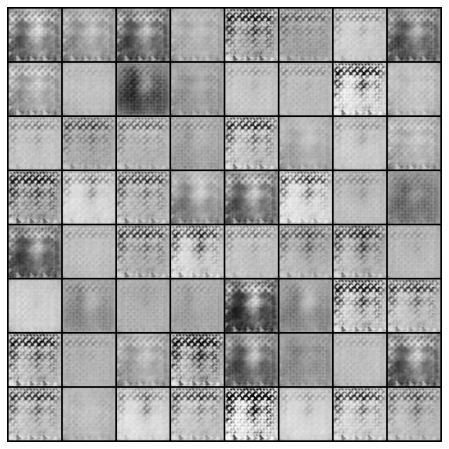

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.1413

[1/100][1/15]
- E_loss: 0.1508

[1/100][2/15]
- E_loss: 0.1049

[1/100][3/15]
- E_loss: 0.1166

[1/100][4/15]
- E_loss: 0.1375

[1/100][5/15]
- E_loss: 0.1091

[1/100][6/15]
- E_loss: 0.1340

[1/100][7/15]
- E_loss: 0.1429

[1/100][8/15]
- E_loss: 0.1111

[1/100][9/15]
- E_loss: 0.1311

[1/100][10/15]
- E_loss: 0.1289

[1/100][11/15]
- E_loss: 0.1014

[1/100][12/15]
- E_loss: 0.1162

[1/100][13/15]
- E_loss: 0.0972

[1/100][14/15]
- E_loss: 0.1233

[2/100][0/15]
- E_loss: 0.1280

[2/100][1/15]
- E_loss: 0.1264

[2/100][2/15]
- E_loss: 0.1142

[2/100][3/15]
- E_loss: 0.0923

[2/100][4/15]
- E_loss: 0.1251

[2/100][5/15]
- E_loss: 0.1001

[2/100][6/15]
- E_loss: 0.1039

[2/100][7/15]
- E_loss: 0.0846

[2/100][8/15]
- E_loss: 0.1252

[2/100][9/15]
- E_loss: 0.1048

[2/100][10/15]
- E_loss: 0.0683

[2/100][11/15]
- E_loss: 0.1002

[2/100][12/15]
- E_loss: 0.0868

[2/100][13/15]
- E_loss: 0.0989

[2/100][14/15]
- E_loss: 0.0543

[3/100][0/15]
- E_loss: 0.0813

[17/100][10/15]
- E_loss: 0.0445

[17/100][11/15]
- E_loss: 0.0639

[17/100][12/15]
- E_loss: 0.0422

[17/100][13/15]
- E_loss: 0.0639

[17/100][14/15]
- E_loss: 0.0628

[18/100][0/15]
- E_loss: 0.0631

[18/100][1/15]
- E_loss: 0.0652

[18/100][2/15]
- E_loss: 0.0799

[18/100][3/15]
- E_loss: 0.0558

[18/100][4/15]
- E_loss: 0.0538

[18/100][5/15]
- E_loss: 0.0497

[18/100][6/15]
- E_loss: 0.0626

[18/100][7/15]
- E_loss: 0.0559

[18/100][8/15]
- E_loss: 0.0492

[18/100][9/15]
- E_loss: 0.0418

[18/100][10/15]
- E_loss: 0.0531

[18/100][11/15]
- E_loss: 0.0644

[18/100][12/15]
- E_loss: 0.0633

[18/100][13/15]
- E_loss: 0.0547

[18/100][14/15]
- E_loss: 0.0501

[19/100][0/15]
- E_loss: 0.0562

[19/100][1/15]
- E_loss: 0.0600

[19/100][2/15]
- E_loss: 0.0466

[19/100][3/15]
- E_loss: 0.0491

[19/100][4/15]
- E_loss: 0.0903

[19/100][5/15]
- E_loss: 0.0503

[19/100][6/15]
- E_loss: 0.0463

[19/100][7/15]
- E_loss: 0.0532

[19/100][8/15]
- E_loss: 0.0507

[19/100][9/15]
- E_loss: 0.0699



[34/100][2/15]
- E_loss: 0.0744

[34/100][3/15]
- E_loss: 0.0494

[34/100][4/15]
- E_loss: 0.0439

[34/100][5/15]
- E_loss: 0.0609

[34/100][6/15]
- E_loss: 0.0540

[34/100][7/15]
- E_loss: 0.0606

[34/100][8/15]
- E_loss: 0.0540

[34/100][9/15]
- E_loss: 0.0614

[34/100][10/15]
- E_loss: 0.0536

[34/100][11/15]
- E_loss: 0.0608

[34/100][12/15]
- E_loss: 0.0556

[34/100][13/15]
- E_loss: 0.0423

[34/100][14/15]
- E_loss: 0.0588

[35/100][0/15]
- E_loss: 0.0515

[35/100][1/15]
- E_loss: 0.0643

[35/100][2/15]
- E_loss: 0.0508

[35/100][3/15]
- E_loss: 0.0455

[35/100][4/15]
- E_loss: 0.0437

[35/100][5/15]
- E_loss: 0.0601

[35/100][6/15]
- E_loss: 0.0633

[35/100][7/15]
- E_loss: 0.0536

[35/100][8/15]
- E_loss: 0.0617

[35/100][9/15]
- E_loss: 0.0634

[35/100][10/15]
- E_loss: 0.0579

[35/100][11/15]
- E_loss: 0.0442

[35/100][12/15]
- E_loss: 0.0642

[35/100][13/15]
- E_loss: 0.0580

[35/100][14/15]
- E_loss: 0.0661

[36/100][0/15]
- E_loss: 0.0626

[36/100][1/15]
- E_loss: 0.0572



[50/100][8/15]
- E_loss: 0.0548

[50/100][9/15]
- E_loss: 0.0758

[50/100][10/15]
- E_loss: 0.0469

[50/100][11/15]
- E_loss: 0.0677

[50/100][12/15]
- E_loss: 0.0660

[50/100][13/15]
- E_loss: 0.0613

[50/100][14/15]
- E_loss: 0.0506

[51/100][0/15]
- E_loss: 0.0554

[51/100][1/15]
- E_loss: 0.0619

[51/100][2/15]
- E_loss: 0.0559

[51/100][3/15]
- E_loss: 0.0617

[51/100][4/15]
- E_loss: 0.0509

[51/100][5/15]
- E_loss: 0.0432

[51/100][6/15]
- E_loss: 0.0524

[51/100][7/15]
- E_loss: 0.0676

[51/100][8/15]
- E_loss: 0.0515

[51/100][9/15]
- E_loss: 0.0700

[51/100][10/15]
- E_loss: 0.0503

[51/100][11/15]
- E_loss: 0.0566

[51/100][12/15]
- E_loss: 0.0527

[51/100][13/15]
- E_loss: 0.0495

[51/100][14/15]
- E_loss: 0.0726

[52/100][0/15]
- E_loss: 0.0510

[52/100][1/15]
- E_loss: 0.0554

[52/100][2/15]
- E_loss: 0.0608

[52/100][3/15]
- E_loss: 0.0366

[52/100][4/15]
- E_loss: 0.0765

[52/100][5/15]
- E_loss: 0.0514

[52/100][6/15]
- E_loss: 0.0588

[52/100][7/15]
- E_loss: 0.0712



[66/100][14/15]
- E_loss: 0.0836

[67/100][0/15]
- E_loss: 0.0581

[67/100][1/15]
- E_loss: 0.0519

[67/100][2/15]
- E_loss: 0.0568

[67/100][3/15]
- E_loss: 0.0564

[67/100][4/15]
- E_loss: 0.0456

[67/100][5/15]
- E_loss: 0.0595

[67/100][6/15]
- E_loss: 0.0529

[67/100][7/15]
- E_loss: 0.0630

[67/100][8/15]
- E_loss: 0.0535

[67/100][9/15]
- E_loss: 0.0536

[67/100][10/15]
- E_loss: 0.0454

[67/100][11/15]
- E_loss: 0.0574

[67/100][12/15]
- E_loss: 0.0579

[67/100][13/15]
- E_loss: 0.0491

[67/100][14/15]
- E_loss: 0.0577

[68/100][0/15]
- E_loss: 0.0526

[68/100][1/15]
- E_loss: 0.0557

[68/100][2/15]
- E_loss: 0.0524

[68/100][3/15]
- E_loss: 0.0487

[68/100][4/15]
- E_loss: 0.0492

[68/100][5/15]
- E_loss: 0.0499

[68/100][6/15]
- E_loss: 0.0438

[68/100][7/15]
- E_loss: 0.0522

[68/100][8/15]
- E_loss: 0.0633

[68/100][9/15]
- E_loss: 0.0638

[68/100][10/15]
- E_loss: 0.0678

[68/100][11/15]
- E_loss: 0.0552

[68/100][12/15]
- E_loss: 0.0617

[68/100][13/15]
- E_loss: 0.0457



[83/100][6/15]
- E_loss: 0.0529

[83/100][7/15]
- E_loss: 0.0549

[83/100][8/15]
- E_loss: 0.0545

[83/100][9/15]
- E_loss: 0.0565

[83/100][10/15]
- E_loss: 0.0490

[83/100][11/15]
- E_loss: 0.0467

[83/100][12/15]
- E_loss: 0.0423

[83/100][13/15]
- E_loss: 0.0594

[83/100][14/15]
- E_loss: 0.0489

[84/100][0/15]
- E_loss: 0.0645

[84/100][1/15]
- E_loss: 0.0717

[84/100][2/15]
- E_loss: 0.0392

[84/100][3/15]
- E_loss: 0.0502

[84/100][4/15]
- E_loss: 0.0459

[84/100][5/15]
- E_loss: 0.0498

[84/100][6/15]
- E_loss: 0.0553

[84/100][7/15]
- E_loss: 0.0635

[84/100][8/15]
- E_loss: 0.0504

[84/100][9/15]
- E_loss: 0.0459

[84/100][10/15]
- E_loss: 0.0715

[84/100][11/15]
- E_loss: 0.0578

[84/100][12/15]
- E_loss: 0.0596

[84/100][13/15]
- E_loss: 0.0508

[84/100][14/15]
- E_loss: 0.0498

[85/100][0/15]
- E_loss: 0.0544

[85/100][1/15]
- E_loss: 0.0515

[85/100][2/15]
- E_loss: 0.0594

[85/100][3/15]
- E_loss: 0.0487

[85/100][4/15]
- E_loss: 0.0600

[85/100][5/15]
- E_loss: 0.0544



[99/100][12/15]
- E_loss: 0.0527

[99/100][13/15]
- E_loss: 0.0580

[99/100][14/15]
- E_loss: 0.0613

[100/100][0/15]
- E_loss: 0.0621

[100/100][1/15]
- E_loss: 0.0544

[100/100][2/15]
- E_loss: 0.0627

[100/100][3/15]
- E_loss: 0.0504

[100/100][4/15]
- E_loss: 0.0415

[100/100][5/15]
- E_loss: 0.0508

[100/100][6/15]
- E_loss: 0.0482

[100/100][7/15]
- E_loss: 0.0458

[100/100][8/15]
- E_loss: 0.0632

[100/100][9/15]
- E_loss: 0.0483

[100/100][10/15]
- E_loss: 0.0557

[100/100][11/15]
- E_loss: 0.0617

[100/100][12/15]
- E_loss: 0.0720

[100/100][13/15]
- E_loss: 0.0656

[100/100][14/15]
- E_loss: 0.0494



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

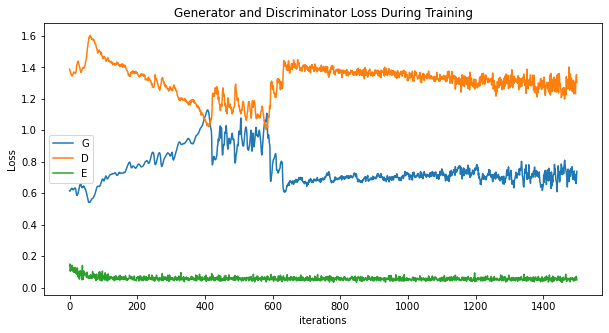

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

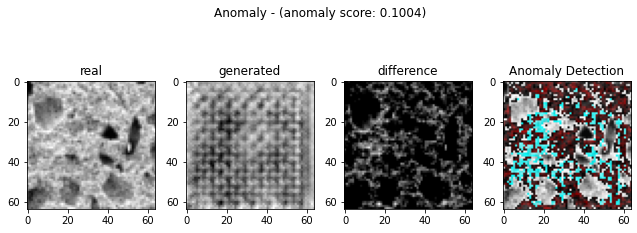

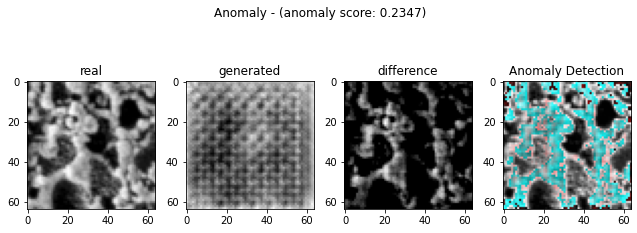

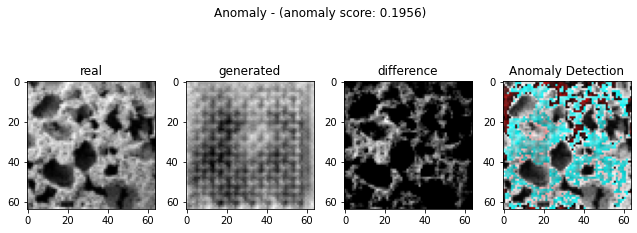

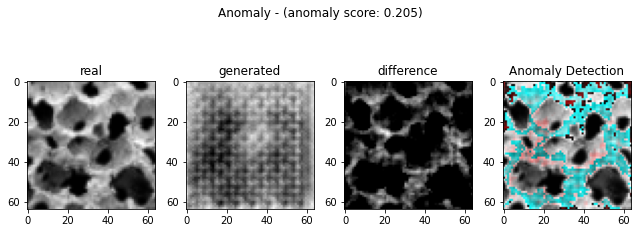

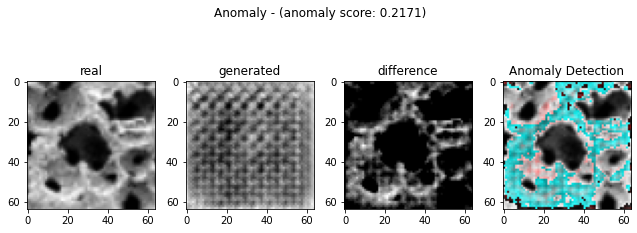

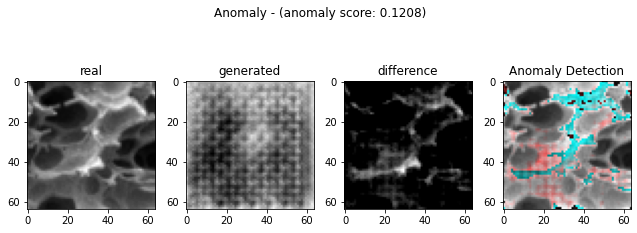

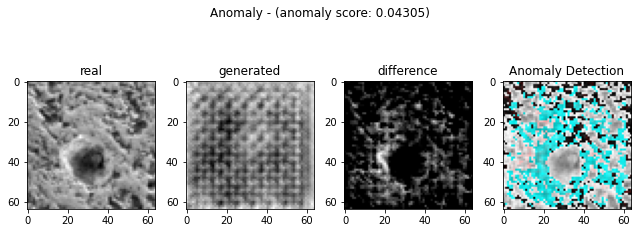

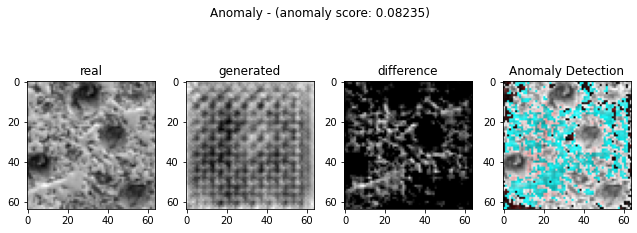

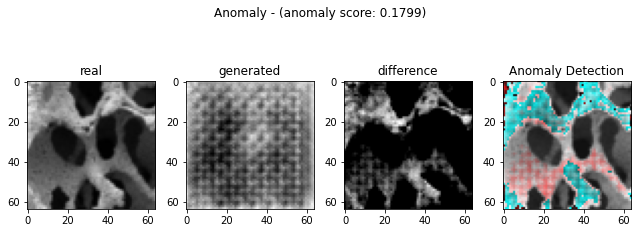

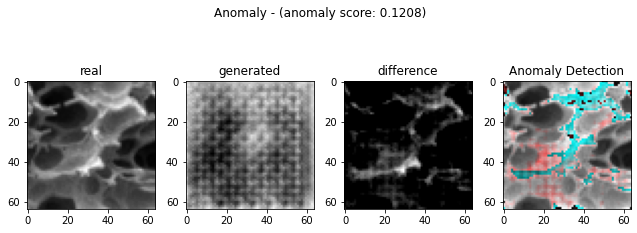

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.54443359 0.49438477 0.52685547 0.50048828 0.53564453 0.3972168
 0.50512695 0.52441406 0.47167969 0.3972168 ]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.48974609375

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.000588948277656709, 0.0563274080289851, 0.021680657192401635, -0.06605526319636858, -0.14593294790032543, -0.2698933715890788, 0.021665226906141862, -0.10272235687522215, 0.021616974853243084, -0.2698933715890788]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

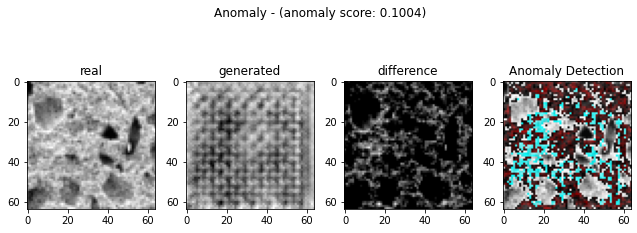

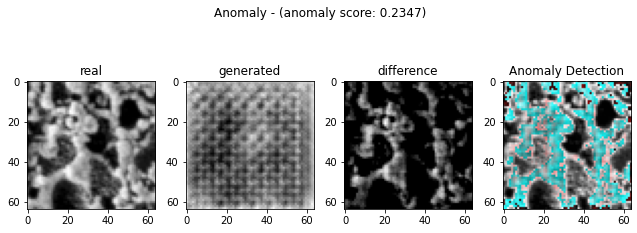

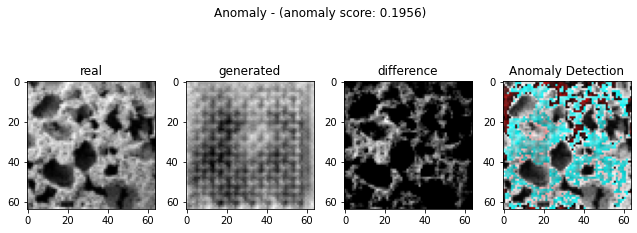

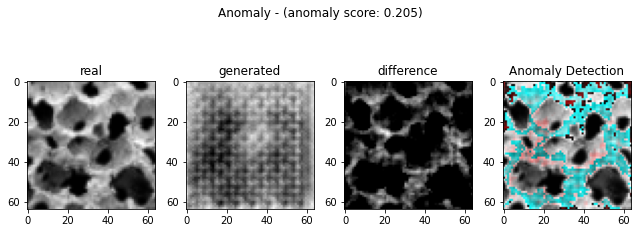

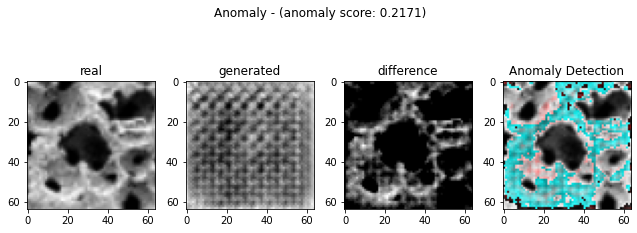

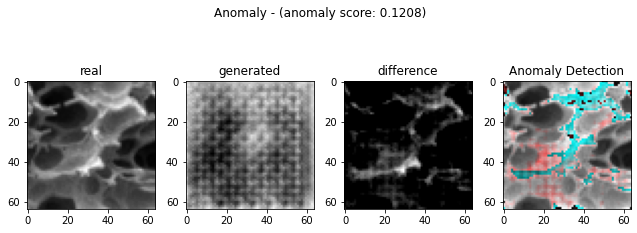

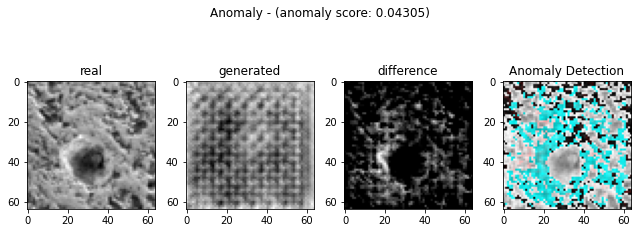

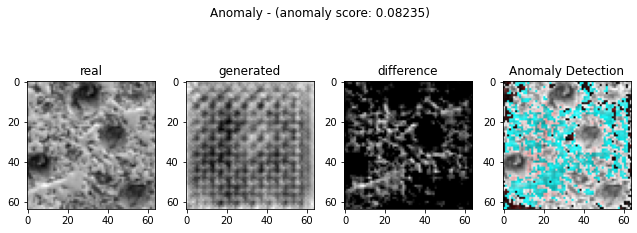

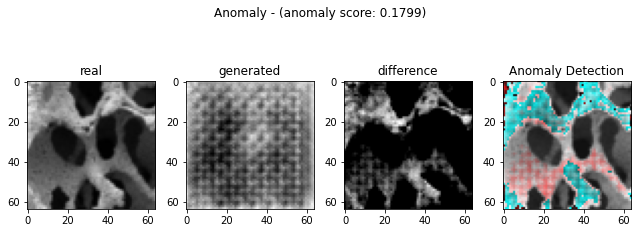

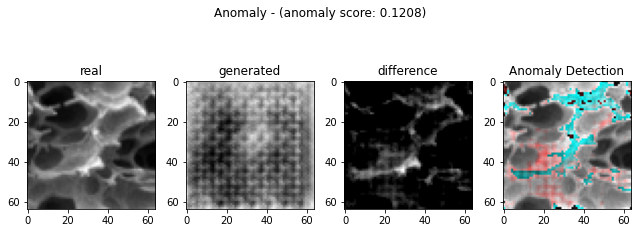

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.54443359 0.49438477 0.52685547 0.50048828 0.53564453 0.3972168
 0.50512695 0.52441406 0.47167969 0.3972168 ]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.000588948277656709, 0.0563274080289851, 0.021680657192401635, -0.06605526319636858, -0.14593294790032543, -0.2698933715890788, 0.021665226906141862, -0.10272235687522215, 0.021616974853243084, -0.2698933715890788]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [186, 186, 186],
         [113,  27,  27],
         ...,
         [ 51,  28,  28],
         [117,  30,  30],
         [111,  31,  31]],
 
        [[  5,   5,   5],
         [ 35,  35,  35],
         [204, 204, 204],
         ...,
         [ 49,  42,  42],
         [ 61,  53,  53],
         [ 53,  45,  45]],
 
        [[  7,   7,   7],
         [  9,   9,   9],
         [ 57,  57,  57],
         ...,
         [192, 192, 192],
         [238, 238, 238],
         [ 75,  45,  45]],
 
        ...,
 
        [[113, 113, 113],
         [158, 158, 158],
         [184, 184, 184],
         ...,
         [ 55,  38,  38],
         [ 45,  45,  45],
         [ 53,  51,  51]],
 
        [[132, 132, 132],
         [176, 176, 176],
         [202, 202, 202],
         ...,
         [246, 246, 246],
         [ 17,  17,  17],
         [ 41,  41,  41]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [162, 162, 162],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[2.41184082 2.19012451 2.33396973 2.21716309 2.37290527 1.75967041
 2.2377124  2.3231543  2.08954102 1.75967041]
